In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

%matplotlib inline

In [30]:
df = pd.read_csv('./data/titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA (Exploratory Data Analysis) 

## Numerik vs Target (histogram) 

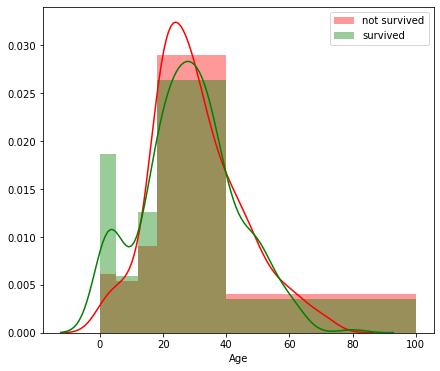

In [10]:
# plot melihat hubungan antara data umur terhadap kolom target (survived)
plt.figure(figsize=(7,6))
sns.distplot(df.query('Survived == 0')['Age'], bins=[0, 5, 12, 18, 40, 100],
            color='r', label='not survived')
sns.distplot(df.query('Survived == 1')['Age'], bins=[0, 5, 12, 18, 40, 100],
            color='g', label='survived')
plt.legend();

Berdasarkan binning, kita mau coba data pada kolom Age kita ubah sebagai kategori. Kelas kategorinya adalah:
- bayi
- balita
- anak-anak
- dst.

In [11]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

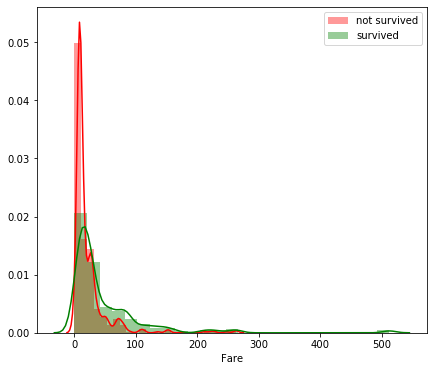

In [12]:
# plot melihat hubungan antara harga tiket dengan kolom target (survived)
plt.figure(figsize=(7, 6))
sns.distplot(df.query('Survived == 0')['Fare'], bins=25, color='r', label='not survived')
sns.distplot(df.query('Survived == 1')['Fare'], bins=25, color='g', label='survived')
plt.legend();

Untuk harga tiket, mungkin bisa kita binning jadi:
- murah
- standard
- mahal

# Kategori vs Target

In [13]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


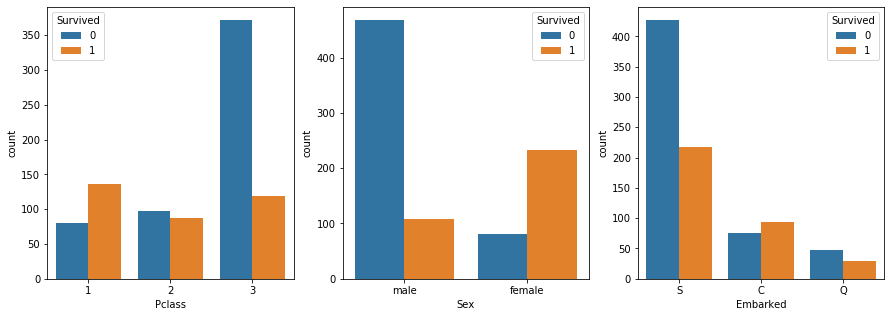

In [14]:
category_variables = ['Pclass', 'Sex', 'Embarked']

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for category, a in zip(category_variables, ax.flatten()):
    sns.countplot(category, data=df, hue='Survived', ax= a)

# Feature Engineering 

- Ekstrak prefix dari nama orang (Mr, Miss, Mrs, etc)
- Binning Age jadi beberapa kelas / kategori
- Binning Fare jadi beberapa kelas / kategori

### Ekstrak prefix 

In [27]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Prefix
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr.
2,1,1,female,38.0,1,0,71.2833,C,Mrs.
3,1,3,female,26.0,0,0,7.9250,S,Miss.
4,1,1,female,35.0,1,0,53.1000,S,Mrs.
5,0,3,male,35.0,0,0,8.0500,S,Mr.


In [37]:
df['Name'][1].split(', ')[1].split('. ')[0]

'Mr'

In [38]:
# mendapatkan data prefix pada kolom Name
def get_prefix(name):
    name = name.split(', ')[1].split('. ')[0]
    return name

df['Prefix'] = df['Name'].apply(get_prefix)

In [40]:
df.drop(columns='Name', inplace=True)

In [39]:
df['Prefix'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
the Countess      1
Don               1
Ms                1
Capt              1
Mme               1
Sir               1
Lady              1
Jonkheer          1
Name: Prefix, dtype: int64

Mengingat kita akan melakukan train-test-split, prefix yang berjumlah 1 hanya akan muncul di data train saja atau data test saja. Maka treatment yang dilakukan adalah untuk prefix dengan count < 10, kita map sebagai `others`.

In [44]:
prefix_fix = ['Mr', 'Miss', 'Mrs', 'Master']

# ini dimulai dari 1 karena kita menggunakan passengerId
for i in range(1, len(df)):
    if df['Prefix'][i] not in prefix_fix:
        df['Prefix'][i] = 'Others'

/home/naufalabdila/miniconda3/envs/jlml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


```python
def change_prefix(prefix, list_prefix):
    if prefix not in list_prefix:
        prefix = 'Others'
    return prefix
```

In [45]:
df['Prefix'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Others     27
Name: Prefix, dtype: int64

### Binning Age 

Membuat data numerik pada kolom Age menjadi data kategorik dengan melakukan binning

In [47]:
df['Age'] = pd.cut(df['Age'], [0, 5, 12, 18, 40, 100], labels=['bayi', 'anak-anak', 'remaja', 'dewasa', 'lansia'])

### Binning Fare 

Membuat data numerik pada kolom Fare menjadi data kategorik dengan melakukan binning

In [49]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [50]:
df['Fare'] = pd.cut(df['Fare'], [0, 7, 14, 31, 513], labels=['murah', 'standard', 'mahal', 'super_mahal'])

## Cek dataframe 

Drop column yang tidak digunakan

In [52]:
df.drop(columns=['Ticket', 'Cabin'], inplace=True)

# Training the model 

## Dataset splitting 

In [54]:
X = df.drop(columns='Survived')
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

## Preprocessor 

In [56]:
X_train.head(1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Prefix
PassengerId,,,,,,,,
693,3,male,NaN,0,0,super_mahal,S,Mr


In [57]:
# buat numerical dan categorical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

# bungkus pipeline dengan columntransformer
preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ['SibSp', 'Parch']),
    ('categoric', categorical_pipeline, ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Prefix'])
])

## Prepare tuning parameter 

In [58]:
parameter = {
    "algo__n_neighbors": range(1, 51, 2), #tuning tetangga terdekat
    "algo__weights": ['uniform', 'distance'], #tuning bobot jarak
    "algo__p": [1, 2, 3] #tuning perhitungan distance
} 

## Training 

In [59]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, parameter, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 735 out of 750 | elapsed:   21.6s remaining:    0.4s


{'algo__n_neighbors': 19, 'algo__p': 2, 'algo__weights': 'uniform'}
0.8230337078651685 0.818831872352999 0.8212290502793296


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   21.9s finished


Feature engineering nya worth it karena hasil train score sama test score sangat bagus (tidak overfit atau underfit)

Overfit = score data train tinggi tapi data test rendah <br>
Underfit = score data train rendah dan data test juga rendah

## Always start with a simple model

Simple model: lansung modelling tanpa melakukan Feature Engineering